# 3WM gain and TWPAnalysis

This tutorial demonstrates how to utilize the `twpasolver.TWPAnalysis` class to simulate the gain response of a TWPA by solving the Coupled Mode Equations (CMEs) with a minimal model.

### Overivew
`twpasolver.TWPAnalysis` automates the procedures required to compute the gain characteristics of a TWPA model.

Implemented features:

* Calculation of phase-matching profile, gain and bandwidth.
* Automatic caching of data from the respectve `phase_matching()`, `gain()` and `bandwidth()` methods.
* Sweeps over lists of input parameters for the analysis functions.
* Simple plots.

### Example - Setup

Let's start by importing the required libraries and initializing the `TWPAnalysis` instance. This object requires:
* A `TWPA` instance or the name of a json file containing the definition of the model
* A frequency span which determines the full region that will be considered in the analysis, which can be provided either as a list of values or a tuple that will be passed to `numpy.arange`. Some precautions in choosing the frequency span must be taken to correctly unwrap the phase response of the device. Namely, the frequency array should be dense enough and should start from frequencies much lower than the position of the stopband.

The computed response and results of the following analysis functions are stored in the internal `data` dictionary, which can be accessed and saved to an hdf5 file through the `save_data()` method.

{'Z0_ref': 50.0,
 'N': 500,
 'cells': [{'Z0_ref': 50.0,
   'N': 30,
   'name': 'LCLfBaseCell',
   'L': 4.99e-11,
   'C': 2.42e-14,
   'Lf': 8.7e-10,
   'delta': 0.0001,
   'centered': False},
  {'Z0_ref': 50.0,
   'N': 6,
   'name': 'LCLfBaseCell',
   'L': 4.86e-11,
   'C': 8.2e-15,
   'Lf': 2.8e-10,
   'delta': 0.0001,
   'centered': False},
  {'Z0_ref': 50.0,
   'N': 30,
   'name': 'LCLfBaseCell',
   'L': 4.99e-11,
   'C': 2.42e-14,
   'Lf': 8.7e-10,
   'delta': 0.0001,
   'centered': False}],
 'name': 'TWPA',
 'Istar': 0.005,
 'Idc': 0.001,
 'Ip0': 0.00025,
 'N_tot': 33000,
 'epsilon': 76.92307692307692,
 'xi': 38461.53846153846,
 'chi': 0.0003004807692307692,
 'alpha': 1.04,
 'Iratio': 0.2}

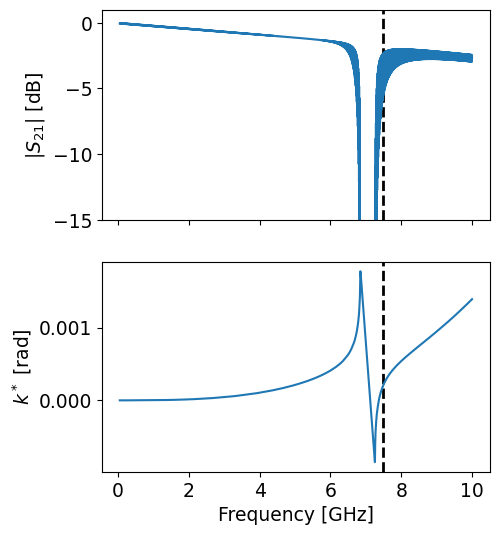

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from twpasolver import TWPAnalysis
from twpasolver.logger import log
from twpasolver.mathutils import dBm_to_I

log.setLevel(logging.WARNING)

plt.rcParams["font.size"] = 13.5
plt.rcParams["axes.axisbelow"] = True

twpa_file = "model_cpw_dartwars_13nm_Lk8_5.json"
a = TWPAnalysis(twpa=twpa_file, f_arange=(0.05, 10, 0.5e-3))
a.update_base_data()  # compute response, estimate stopband position and optimal pump frequency
ax = a.plot_response(pump_freq=a.data["optimal_pump_freq"])
ax[0].set_ylim(-15, 1)
a.twpa.model_dump()

### Phase matching

This is the first analysis function implemented by the class. It computes the phase matching condition as a function of pump and signal frequency. By default, the signal range is chosen from the start of the total frequency span to the beginning of the stopband, while the pump range is chosen from the end of the stopband to the maximum of the full span.

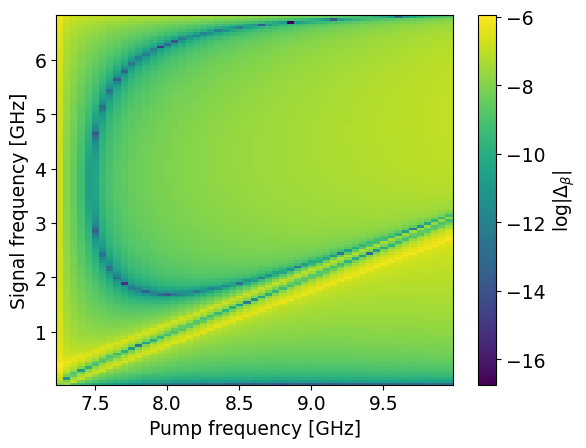

In [2]:
_ = a.phase_matching()
ax = a.plot_phase_matching(thin=5)

### Gain and bandwidth
Since `twpasolver` uses a numba-based implementation of the Runge-Kutta algorithm to solve the CMEs, it may take some seconds to compile all the functions when the `gain` method is called for the first time, becoming much faster afterwards.

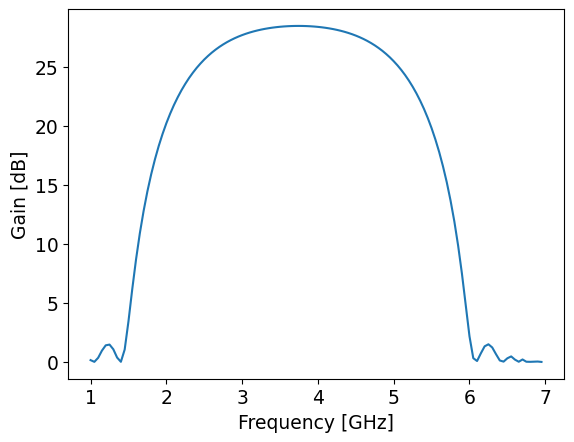

In [3]:
s_arange = np.arange(1, 7, 0.05)
_ = a.gain(signal_freqs=s_arange, Is0=1e-6)
a.plot_gain()
plt.show()

The `bandwidth` analysis function computes the bandwidth by finding all the regions between the maximum gain value and a certain threshold, by default defined as 3 dB lower than the maximum gain. It is designed to keep track of the asymmetry and formation of lobes in the gain profile due to depleted pump effects and high pump frequency choice, potentially computing the bandwidth over discontinuous regions.

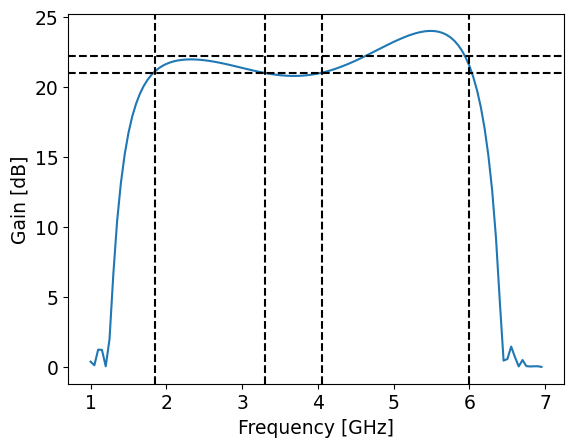

In [4]:
_ = a.gain(signal_freqs=s_arange, Is0=1e-5, pump=a.data["optimal_pump_freq"] + 0.2)
a.plot_gain()
_ = a.bandwidth()
for edg in a.data["bandwidth"]["bandwidth_edges"]:
    plt.axvline(edg, color="black", ls="--")
plt.axhline(a.data["bandwidth"]["reduced_gain"], c="black", ls="--")
plt.axhline(a.data["bandwidth"]["mean_gain"], c="black", ls="--")
plt.show()

### Parameter sweeps

The `parameter_sweep` analysis method allows performing sweeps over an input variable for one of the other analysis functions. Basic usage involves passing as the first three positional arguments of a sweep the name of the target function, the name of the target variable and its list of values.

#### Gain as a function of pump frequency

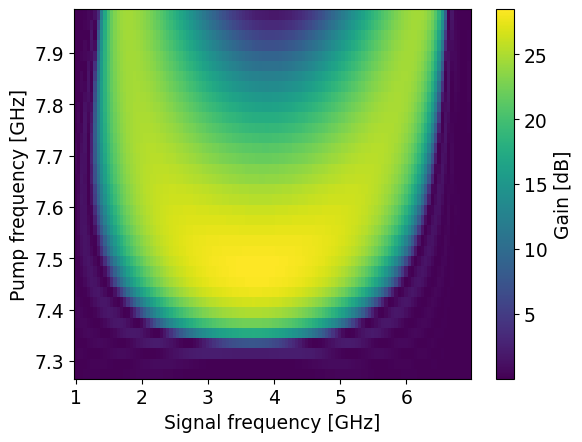

In [5]:
optimal = a.data["optimal_pump_freq"]
pumps = np.arange(optimal - 0.2, optimal + 0.5, 0.02)
pumpsweep_res = a.parameter_sweep(
    "gain", "pump", pumps, signal_freqs=s_arange, save_name="pump_profile"
)

plt.pcolor(pumpsweep_res["signal_freqs"][0], pumps, pumpsweep_res["gain_db"])
plt.xlabel("Signal frequency [GHz]")
plt.ylabel("Pump frequency [GHz]")
c = plt.colorbar()
c.set_label("Gain [dB]")
plt.show()

#### Compression point

Since the default CMEs system considers pump depletion effects, it is possible to simulate power-dependent measurements such as the compression point.

In [6]:
signals_db = np.arange(-80, -40, 1)
signals = dBm_to_I(signals_db)
edges = a.data["bandwidth"]["bandwidth_edges"]
s_arange = a.data["bandwidth"]["bw_freqs"]  # (edges[0], edges[-1], 0.1)
compression_res = a.parameter_sweep(
    "gain", "Is0", signals, signal_freqs=s_arange, thin=1000, save_name="compression"
)

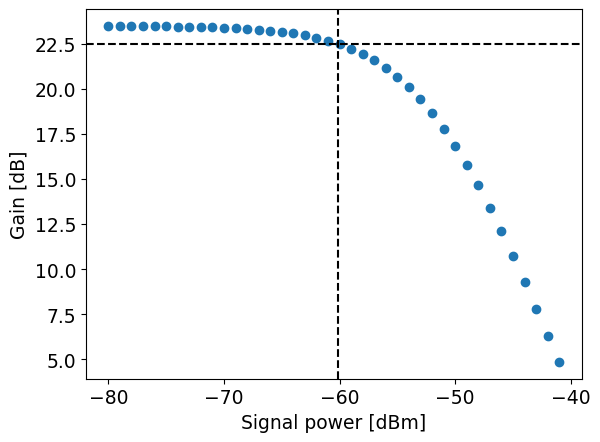

In [7]:
mean_gains = np.mean(compression_res["gain_db"], axis=1)
reduced_1db = mean_gains[0] - 1
cp_1db = np.interp(reduced_1db, mean_gains[::-1], signals_db[::-1])
plt.scatter(signals_db, mean_gains)
plt.xlabel("Signal power [dBm]")
plt.ylabel("Gain [dB]")
plt.axhline(reduced_1db, c="black", ls="--")
plt.axvline(cp_1db, c="black", ls="--")
plt.show()